# 生成对抗网络-修改了原始image和生成image的loss
前面我们讲了自动编码器和变分自动编码器，不管是哪一个，都是通过计算生成图像和输入图像在每个像素点的误差来生成 loss，这一点是特别不好的，因为不同的像素点可能造成不同的视觉结果，但是可能他们的 loss 是相同的，所以通过单个像素点来得到 loss 是不准确的，这个时候我们需要一种全新的 loss 定义方式，就是通过对抗进行学习。

## GANs
这种训练方式定义了一种全新的网络结构，就是生成对抗网络，也就是 GANs。这一部分，我们会形象地介绍生成对抗网络，以及用代码进行实现，而在书中会更加详细地介绍 GANs 的数学推导。

根据这个名字就可以知道这个网络是由两部分组成的，第一部分是生成，第二部分是对抗。简单来说，就是有一个生成网络和一个判别网络，通过训练让两个网络相互竞争，生成网络来生成假的数据，对抗网络通过判别器去判别真伪，最后希望生成器生成的数据能够以假乱真。

可以用这个图来简单的看一看这两个过程

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22oma081j30k007cgll.jpg)

### Discriminator Network
首先我们来讲一下对抗过程，因为这个过程更加简单。

对抗过程简单来说就是一个判断真假的判别器，相当于一个二分类问题，我们输入一张真的图片希望判别器输出的结果是1，输入一张假的图片希望判别器输出的结果是0。这其实已经和原图片的 label 没有关系了，不管原图片到底是一个多少类别的图片，他们都统一称为真的图片，label 是 1 表示真实的；而生成的假的图片的 label 是 0 表示假的。

我们训练的过程就是希望这个判别器能够正确的判出真的图片和假的图片，这其实就是一个简单的二分类问题，对于这个问题可以用我们前面讲过的很多方法去处理，比如 logistic 回归，深层网络，卷积神经网络，循环神经网络都可以。

### Generator Network
接着我们看看生成网络如何生成一张假的图片。首先给出一个简单的高维的正态分布的噪声向量，如上图所示的 D-dimensional noise vector，这个时候我们可以通过仿射变换，也就是 xw+b 将其映射到一个更高的维度，然后将他重新排列成一个矩形，这样看着更像一张图片，接着进行一些卷积、转置卷积、池化、激活函数等进行处理，最后得到了一个与我们输入图片大小一模一样的噪音矩阵，这就是我们所说的假的图片。

**这个时候我们如何去训练这个生成器呢？这就需要通过对抗学习，增大判别器判别这个结果为真的概率，通过这个步骤不断调整生成器的参数，希望生成的图片越来越像真的，而在这一步中我们不会更新判别器的参数，因为如果判别器不断被优化，可能生成器无论生成什么样的图片都无法骗过判别器。**

生成器的效果可以看看下面的图示

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22s47jnfj30k005c74b.jpg)

关于生成对抗网络，出现了很多变形，比如 WGAN，LS-GAN 等等，这一节我们只使用 mnist 举一些简单的例子来说明，更复杂的网络结构可以再 github 上找到相应的实现

In [7]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader,sampler
import torchvision.transforms as tfs
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
#神奇的magic function主要是matplotlib和jupyter交互
plt.rcParams['figure.figsize']=(10.0,8.0)#设置画图的尺寸
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0

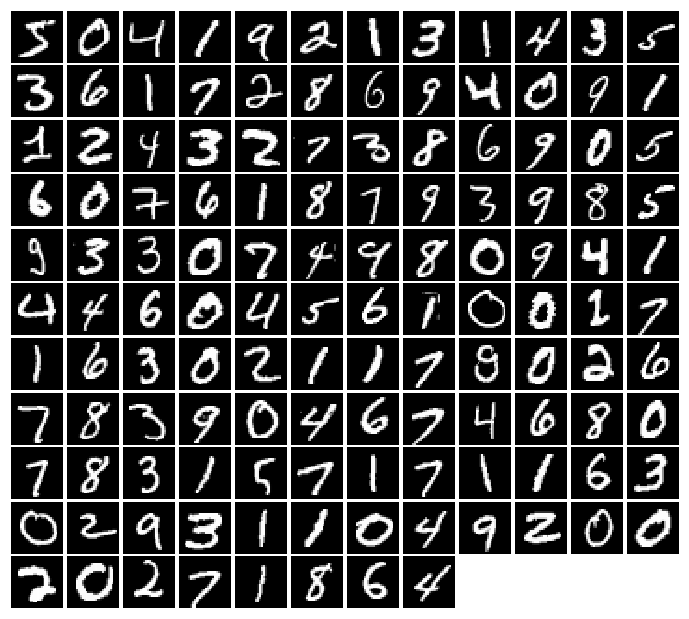

In [8]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs) #自定义函数

## 一. 简单版本的生成对抗网络
通过前面我们知道生成对抗网络有两个部分构成，一个是生成网络，一个是对抗网络，我们首先写一个简单版本的网络结构，生成网络和对抗网络都是简单的多层神经网络

### 判别网络
判别网络的结构非常简单，就是一个二分类器，结构如下:
* 全连接(784 -> 256)
* leakyrelu,  $\alpha$ 是 0.2
* 全连接(256 -> 256)
* leakyrelu, $\alpha$ 是 0.2
* 全连接(256 -> 1)

其中 leakyrelu 是指 f(x) = max($\alpha$ x, x)

In [10]:
def discriminator():
    net=nn.Sequential(nn.Linear(784,256),
                     nn.LeakyReLU(0.2),
                     nn.Linear(256,256),
                     nn.LeakyReLU(0.2),
                     nn.Linear(256,1))
    return net

### 生成网络
接下来我们看看生成网络，生成网络的结构也很简单，就是根据一个随机噪声生成一个和数据维度一样的张量，结构如下：
* 全连接(噪音维度 -> 1024)
* relu
* 全连接(1024 -> 1024)
* relu
* 全连接(1024 -> 784)
* tanh 将数据裁剪到 -1 ~ 1 之间

In [11]:
def generator(noise_dim=NOISE_DIM):
    net=nn.Sequential(nn.Linear(noise_dim,1024),
                     nn.ReLU(True),
                     nn.Linear(1024,1024),
                     nn.ReLU(True),
                     nn.Linear(1024,784),
                     nn.Tanh())
    return net

接下来我们需要定义生成对抗网络的 loss，通过前面的讲解我们知道，对于对抗网络，相当于二分类问题，将真的判别为真的，假的判别为假的，作为辅助，可以参考一下论文中公式(一下应该是目标函数,因为没有负号...)

$$ \ell_D = \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

而对于生成网络，需要去骗过对抗网络，也就是将假的也判断为真的，作为辅助，可以参考一下论文中公式

$$\ell_G  =  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

如果你还记得前面的二分类 loss，那么你就会发现上面这两个公式就是二分类 loss

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

如果我们把 D(x) 看成真实数据的分类得分，那么 D(G(z)) 就是假数据的分类得分，所以上面判别器的 loss 就是将真实数据的得分判断为 1，假的数据的得分判断为 0，而生成器的 loss 就是将假的数据判断为 1

下面我们来实现一下

In [12]:
bce_loss=nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real,logits_fake):
    size=logits_real.shape[0]
    true_labels=Variable(torch.ones(size,1)).float().cuda()
    false_labels=Variable(torch.zeros(size,1)).float().cuda()
    loss=bce_loss(logits_real,true_labels)+bce_loss(logits_fake,false_labels)#判别器的loss
    return loss

In [13]:
def generator_loss(logits_fake):
    size=logits_fake.shape[0]
    true_labels=Variable(torch.ones(size,1)).float().cuda()
    loss=bce_loss(logits_fake,true_labels)
    return loss

In [14]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

下面我们开始训练一个这个简单的生成对抗网络

In [17]:
def train_a_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).view(bs, -1).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data[0], g_error.data[0]))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

C:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, D: 1.413, G:0.7311


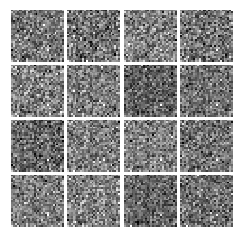


Iter: 250, D: 1.338, G:0.8446


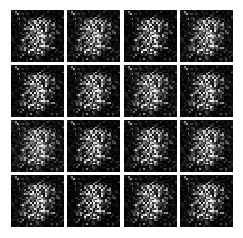


Iter: 500, D: 0.7793, G:1.53


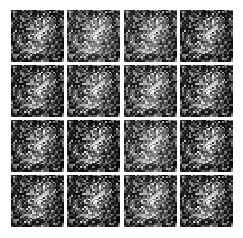


Iter: 750, D: 0.7603, G:1.647


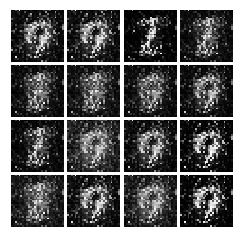


Iter: 1000, D: 1.049, G:3.233


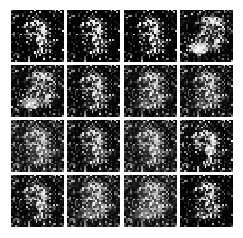


Iter: 1250, D: 0.9485, G:1.802


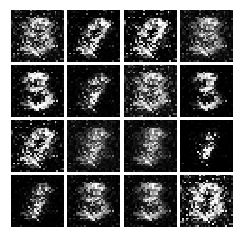


Iter: 1500, D: 1.008, G:1.766


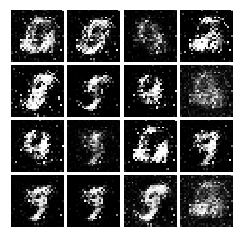


Iter: 1750, D: 1.117, G:1.005


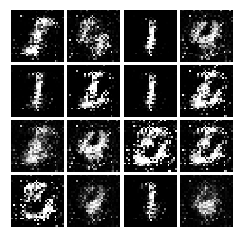


Iter: 2000, D: 0.7211, G:2.249


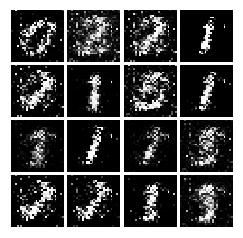


Iter: 2250, D: 0.7896, G:1.607


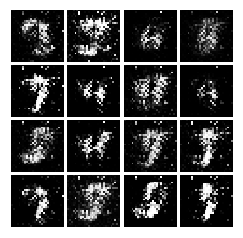


Iter: 2500, D: 1.206, G:1.663


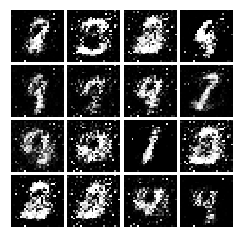


Iter: 2750, D: 0.9872, G:1.115


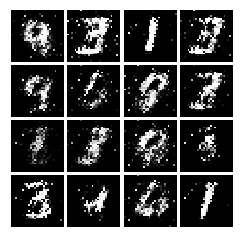


Iter: 3000, D: 1.121, G:1.463


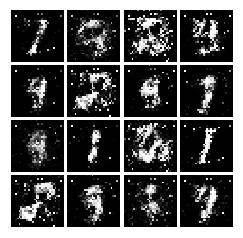


Iter: 3250, D: 0.8531, G:1.504


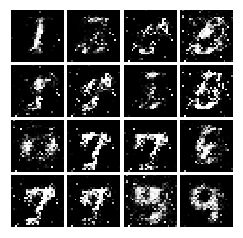


Iter: 3500, D: 0.9658, G:1.386


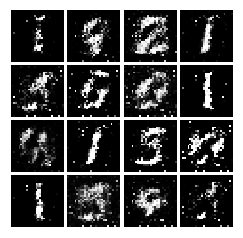


Iter: 3750, D: 1.124, G:1.63


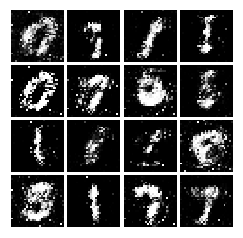

In [18]:
D = discriminator().cuda()#定义判别器模型
G = generator().cuda()#定义生成器模型

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, discriminator_loss, generator_loss)

##  二. GAN改进-Least Square GAN: loss的改进,其他没变.
[Least Squares GAN](https://arxiv.org/abs/1611.04076) 比最原始的 GANs 的 loss 更加稳定，通过名字我们也能够看出这种 GAN 是通过最小平方误差来进行估计，而不是通过二分类的损失函数，下面我们看看 loss 的计算公式

$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

可以看到 Least Squares GAN 通过**最小二乘法**代替了二分类的交叉熵loss，下面我们定义一下 loss 函数

In [19]:
def ls_discriminator_loss(scores_real, scores_fake):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake ** 2).mean()
    return loss

def ls_generator_loss(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()#tensor.mean()
    return loss

C:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, D: 0.526, G:0.4672


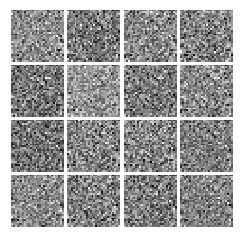


Iter: 250, D: 0.168, G:0.2662


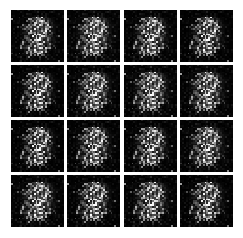


Iter: 500, D: 0.08012, G:0.3757


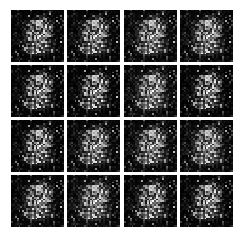


Iter: 750, D: 0.1174, G:0.236


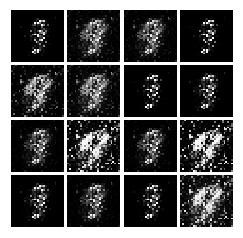


Iter: 1000, D: 0.05133, G:0.4931


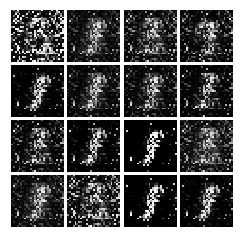


Iter: 1250, D: 0.06009, G:0.5332


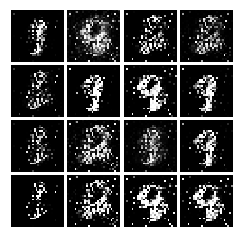


Iter: 1500, D: 0.3015, G:0.8903


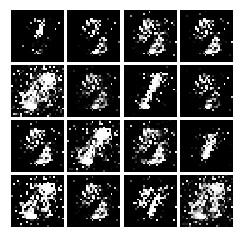


Iter: 1750, D: 0.07857, G:0.2665


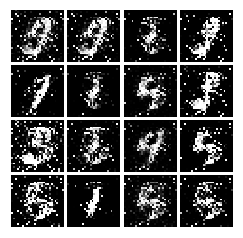


Iter: 2000, D: 0.1065, G:0.4485


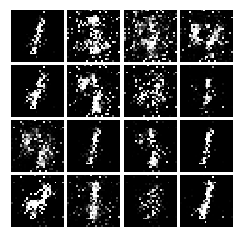


Iter: 2250, D: 0.1106, G:0.3405


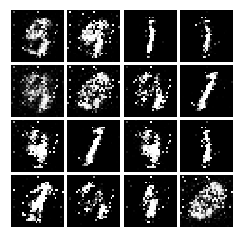


Iter: 2500, D: 0.09307, G:0.3997


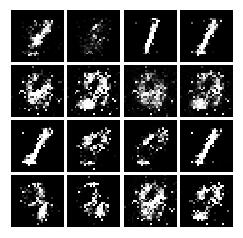


Iter: 2750, D: 0.1559, G:0.1989


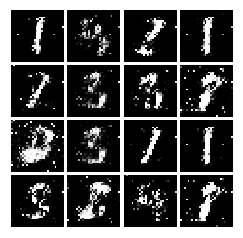


Iter: 3000, D: 0.21, G:0.4685


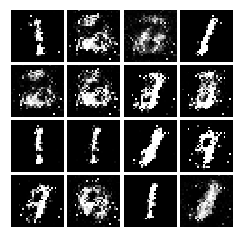


Iter: 3250, D: 0.1289, G:0.276


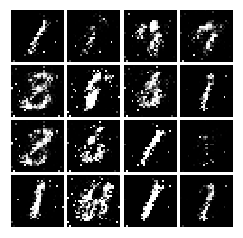


Iter: 3500, D: 0.1784, G:0.3725


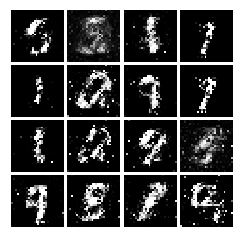


Iter: 3750, D: 0.1728, G:0.3058


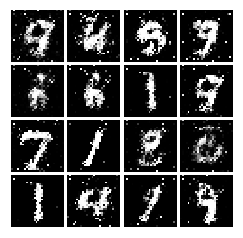

In [22]:
D = discriminator().cuda()
G = generator().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, ls_discriminator_loss, ls_generator_loss)#放入新的loss function

## 三.GAN改进-Deep Convlutional GANs: 网络结构改进
深度卷积生成对抗网络特别简单，就是将生成网络和对抗网络都改成了卷积网络的形式，下面我们来实现一下

### 卷积判别网络
卷积判别网络就是一个一般的卷积网络，结构如下

* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1